In [1]:
import numpy as np 
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


# Initialize environment
env = gym.make('CartPole-v1')

print('observation space:', env.observation_space)
print('action space:', env.action_space)


observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
action space: Discrete(2)


## Policy 

In [2]:
# Define the policy class
class Policy:
    def __init__(self, n_inputs=4, n_outputs=1):
        self.w = np.random.rand(n_outputs, n_inputs)  # Initialize weights randomly

    def act(self, state):
        z = np.dot(self.w, state)
        return 1 if z > 0 else 0


# # Parameters
# n_inputs = env.observation_space.shape[0]
# n_outputs = env.action_space.n
# n_episodes = 1000
# print_every = 50

# # Initialize a baseline policy for all three methods
# baseline_policy = Policy(n_inputs, 1)

In [3]:
# Utility function to evaluate policy
def evaluate_policy(env, policy, max_t=1000):
    rewards = []
    state, info = env.reset()
    for t in range(max_t):
        action = policy.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        if terminated or truncated:
            break
    return sum(rewards), rewards

#### Steepest Ascent Hill Climbing 

is a variation of hill climbing that chooses a small number of neighboring policies at each iteration and chooses the best among them.

In [4]:

def steepest_ascent_hill_climbing(policy, n_episodes=1000, max_t=1000, num_neighbors=10, noise_scale=0.1, gamma=1.0, print_every=100):
    """Implementation of hill climbing with steepest ascent.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        num_neighnors (int): number of neughbors to check 
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.inf
    best_w = policy.w.copy()

    for i_episode in range(1, n_episodes + 1):
        neighbors = [policy.w + noise_scale * np.random.randn(*policy.w.shape) for _ in range(num_neighbors)]
        best_neighbor_score = -np.inf
        best_neighbor_w = None

        for w in neighbors:
            policy.w = w
            score, rewards = evaluate_policy(env, policy, max_t)
            scores_deque.append(score)
            discounted_rewards = [gamma**i * reward for i, reward in enumerate(rewards)]
            R = sum(discounted_rewards)
            
            if R > best_neighbor_score:
                best_neighbor_score = R
                best_neighbor_w = w

        policy.w = best_neighbor_w
        scores.append(best_neighbor_score)
        best_R = max(best_R, best_neighbor_score)

        if i_episode % print_every == 0:
            print(f"Episode {i_episode}, Best Score: {best_R:.2f}, Average Score: {np.mean(scores_deque):.2f}")

        # Early stopping if the policy achieves the goal
        if np.mean(scores_deque) >= 195.0:
            print(f"Environment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_deque):.2f}")
            break

    return scores

Episode 100, Best Score: 11.00, Average Score: 9.62
Environment solved in 111 episodes!	Average Score: 240.96
Environment solved in 1 episodes!	Average Score: 317.60
Environment solved in 6 episodes!	Average Score: 221.62
Environment solved in 5 episodes!	Average Score: 197.24
Environment solved in 1 episodes!	Average Score: 360.80
Environment solved in 8 episodes!	Average Score: 201.93
Environment solved in 11 episodes!	Average Score: 202.07
Environment solved in 5 episodes!	Average Score: 221.12
Environment solved in 2 episodes!	Average Score: 208.80
Environment solved in 3 episodes!	Average Score: 226.07
Environment solved in 1 episodes!	Average Score: 221.50
Environment solved in 1 episodes!	Average Score: 378.90
Environment solved in 1 episodes!	Average Score: 240.60
Environment solved in 4 episodes!	Average Score: 242.43
Environment solved in 13 episodes!	Average Score: 216.96
Environment solved in 11 episodes!	Average Score: 216.07
Episode 100, Best Score: 11.00, Average Score: 

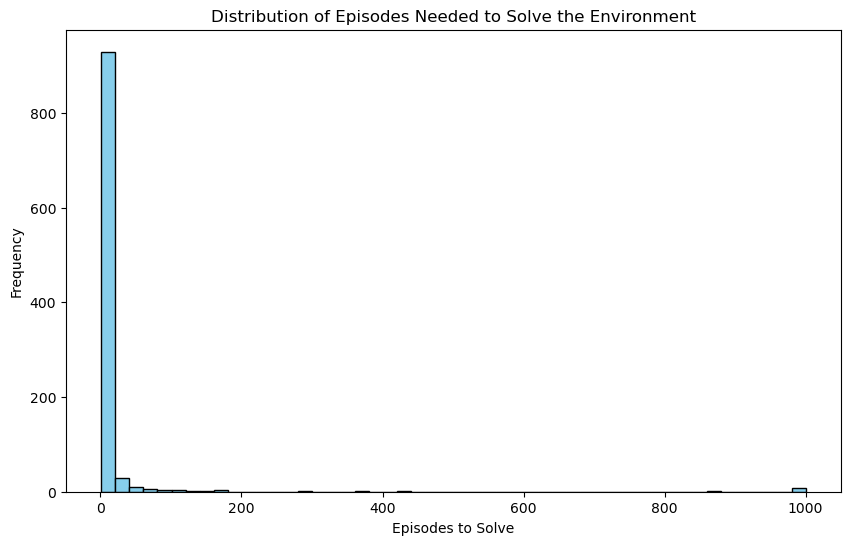

In [5]:
# policy = Policy()
# scores = steepest_ascent_hill_climbing(policy)

episodes_to_solve = []

for run in range(1000):
    policy = Policy()  # Create a new policy for each run
    scores = steepest_ascent_hill_climbing(policy)
    episodes_to_solve.append(len(scores))



# Plot the distribution as a histogram
plt.figure(figsize=(10, 6))
plt.hist(episodes_to_solve, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Episodes to Solve")
plt.ylabel("Frequency")
plt.title("Distribution of Episodes Needed to Solve the Environment")
plt.show()

#### Simulated Annealing    

Uses a pre-defined schedule to control how the policy space is explored, and gradually reduces the search radius as we get closer to the optimal solution.

In [6]:
def simulated_annealing(policy, n_episodes=1000, max_t=1000, initial_noise=1.0, min_noise=0.01, alpha=0.99, gamma=1.0, print_every=100):
    """Implementation of hill climbing with simulated annealing.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        num_neighnors (int): number of neughbors to check 
        initial_noise (float):  starting noise level to add random variations to the policy weights (default is 1.0). 
        min_noise (float): minimum allowable noise level for perturbations (default is 0.01)
        alpha (float):  noise reduction factor after each episode (default is 0.99). A value <1.0 gradually decreases the noise, helping to focus more on exploitation over time.
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    noise_scale = initial_noise
    best_R = -np.inf
    best_w = policy.w.copy()

    for i_episode in range(1, n_episodes + 1):
        candidate_w = policy.w + noise_scale * np.random.randn(*policy.w.shape)
        policy.w = candidate_w
        score, rewards = evaluate_policy(env, policy, max_t)
        scores_deque.append(score)
        discounted_rewards = [gamma**i * reward for i, reward in enumerate(rewards)]
        R = sum(discounted_rewards)

        #his probabilistic acceptance of worse solutions helps the algorithm avoid getting stuck in local optima. 
        # By occasionally allowing worse solutions, the algorithm can "jump out" of local optima in search of a globally better solution.
        if R > best_R or np.random.rand() < noise_scale:
            best_R = R
            best_w = candidate_w

        noise_scale = max(min_noise, noise_scale * alpha)
        policy.w = best_w
        scores.append(best_R)

        # if i_episode % print_every == 0:
            # print(f"Episode {i_episode}, Best Score: {best_R:.2f}, Average Score: {np.mean(scores_deque):.2f}, Noise Scale: {noise_scale:.4f}")

        # Early stopping if the policy achieves the goal
        if np.mean(scores_deque) >= 195.0:
            print(f"Environment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_deque):.2f}")
            break

    return scores

Environment solved in 1 episodes!	Average Score: 420.00
Environment solved in 1 episodes!	Average Score: 304.00
Environment solved in 2 episodes!	Average Score: 255.00
Environment solved in 42 episodes!	Average Score: 196.12
Environment solved in 6 episodes!	Average Score: 219.00
Environment solved in 130 episodes!	Average Score: 195.43
Environment solved in 3 episodes!	Average Score: 269.00
Environment solved in 3 episodes!	Average Score: 242.00
Environment solved in 2 episodes!	Average Score: 195.50
Environment solved in 118 episodes!	Average Score: 195.55
Environment solved in 2 episodes!	Average Score: 275.00
Environment solved in 3 episodes!	Average Score: 232.33
Environment solved in 1 episodes!	Average Score: 500.00
Environment solved in 51 episodes!	Average Score: 196.90
Environment solved in 8 episodes!	Average Score: 195.38
Environment solved in 12 episodes!	Average Score: 204.42
Environment solved in 1 episodes!	Average Score: 500.00
Environment solved in 21 episodes!	Averag

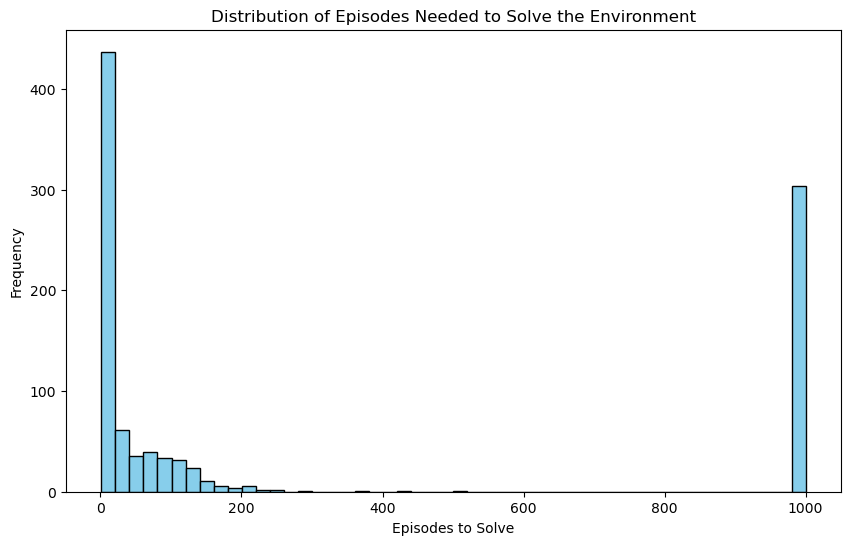

In [7]:
episodes_to_solve = []

for run in range(1000):
    policy = Policy()  # Create a new policy for each run
    scores = simulated_annealing(policy, initial_noise=0.5)
    episodes_to_solve.append(len(scores))

# Plot the distribution as a histogram
plt.figure(figsize=(10, 6))
plt.hist(episodes_to_solve, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Episodes to Solve")
plt.ylabel("Frequency")
plt.title("Distribution of Episodes Needed to Solve the Environment")
plt.show()

#### Adaptive Noise Scaling 
 decreases the search radius with each iteration when a new best policy is found, and otherwise increases the search radius.

In [8]:
def adaptive_noise_scaling(policy, n_episodes=1000, max_t=1000, initial_noise=0.1, max_noise=2.0, min_noise=0.01, gamma=1.0, print_every=100):
    """Implementation of hill climbing with adaptive noise scaling.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    noise_scale = initial_noise
    best_R = -np.inf
    best_w = policy.w.copy()

    for i_episode in range(1, n_episodes + 1):
        candidate_w = policy.w + noise_scale * np.random.randn(*policy.w.shape)
        policy.w = candidate_w
        score, rewards = evaluate_policy(env, policy, max_t)
        scores_deque.append(score)
        discounted_rewards = [gamma**i * reward for i, reward in enumerate(rewards)]
        R = sum(discounted_rewards)

        if R > best_R:
            best_R = R
            best_w = candidate_w
            noise_scale = max(min_noise, noise_scale / 2)
        else:
            noise_scale = min(max_noise, noise_scale * 2)

        policy.w = best_w
        scores.append(best_R)

        # if i_episode % print_every == 0:
            # print(f"Episode {i_episode}, Best Score: {best_R:.2f}, Average Score: {np.mean(scores_deque):.2f}, Noise Scale: {noise_scale:.4f}")

        # Early stopping if the policy achieves the goal
        if np.mean(scores_deque) >= 195.0:
            print(f"Environment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_deque):.2f}")
            break

    return scores

Environment solved in 1 episodes!	Average Score: 469.00
Environment solved in 1 episodes!	Average Score: 500.00
Environment solved in 63 episodes!	Average Score: 196.32
Environment solved in 55 episodes!	Average Score: 195.82
Environment solved in 1 episodes!	Average Score: 209.00
Environment solved in 6 episodes!	Average Score: 213.50
Environment solved in 2 episodes!	Average Score: 255.00
Environment solved in 15 episodes!	Average Score: 201.93
Environment solved in 12 episodes!	Average Score: 206.92
Environment solved in 258 episodes!	Average Score: 195.26
Environment solved in 219 episodes!	Average Score: 199.18
Environment solved in 24 episodes!	Average Score: 203.17
Environment solved in 1 episodes!	Average Score: 196.00
Environment solved in 5 episodes!	Average Score: 242.60
Environment solved in 1 episodes!	Average Score: 409.00
Environment solved in 53 episodes!	Average Score: 195.85
Environment solved in 1 episodes!	Average Score: 500.00
Environment solved in 2 episodes!	Aver

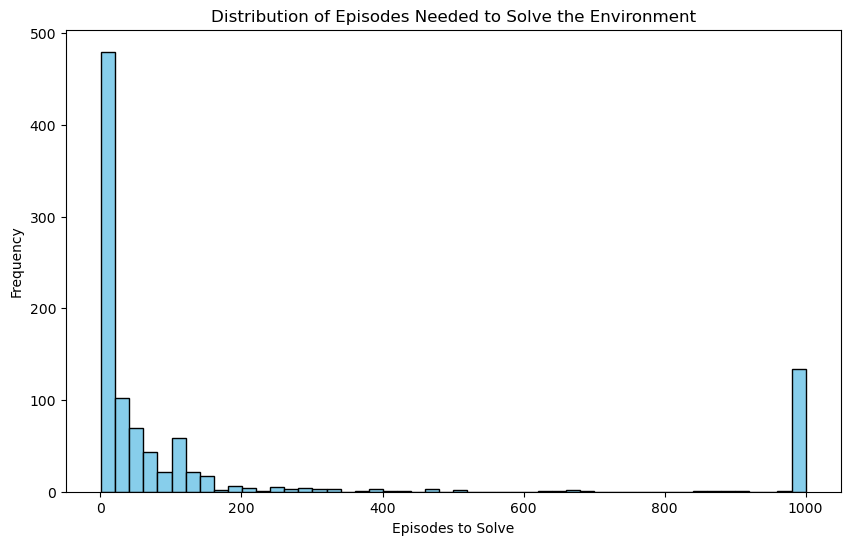

In [9]:
episodes_to_solve = []

for run in range(1000):
    policy = Policy()  # Create a new policy for each run
    scores = adaptive_noise_scaling(policy, initial_noise=0.5)
    episodes_to_solve.append(len(scores))

# Plot the distribution as a histogram
plt.figure(figsize=(10, 6))
plt.hist(episodes_to_solve, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Episodes to Solve")
plt.ylabel("Frequency")
plt.title("Distribution of Episodes Needed to Solve the Environment")
plt.show()

Environment solved in 109 episodes!	Average Score: 195.42


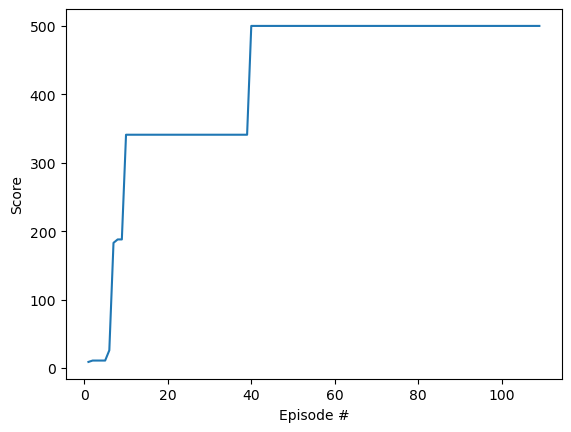

In [10]:
policy = Policy() 
scores = adaptive_noise_scaling(policy)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()